# Importing packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import os
import string
import re
import math
from tqdm import tqdm
from itertools import compress
import scipy.integrate as integrate
from scipy.stats import geom
import seaborn as sns

import pickle

In [2]:
# retina
%config InlineBackend.figure_format = 'retina'

# Checking path

In [3]:
!pwd

/ocean/projects/atm200007p/jlin96


# Creating weightings and reference variables

### Define loading functions

In [4]:
def ls(data_path = ""):
    return os.popen(" ".join(["ls", data_path])).read().splitlines()

def load_data(data_path):
    datasets = ls(data_path)
    datasets = [data_path + x for x in datasets if "h1.000" in x]
    return xr.open_mfdataset(datasets, \
                             compat = 'override', \
                             join = 'override', \
                             coords = "minimal")

### Loading in data

In [5]:
sp_path = "/ocean/projects/atm200007p/jlin96/sp_proxy/spcamTrim/"
sp_data = load_data(sp_path)

### Get monthly averages for temperature and humidity in reference simulation

In [6]:
sp_temp = sp_data["NNTBP"].groupby("time.month").mean("time").values
sp_hum = sp_data["NNQBP"].groupby("time.month").mean("time").values

sp_temp = sp_temp[:, 12:30, :, :] # exclude the stratosphere
sp_hum = sp_hum[:, 12:30, :, :] # exclude the stratosphere

### Calculate error weighting

In [7]:
# ERROR WEIGHTING

dp = sp_data['gw'] * (sp_data["P0"] * sp_data["hyai"] + sp_data['hybi']*sp_data['NNPS']).diff(dim = "ilev")
error_weights = dp.groupby('time.month').mean('time')
error_weights = error_weights.isel(ilev = slice(12, 30))
error_weights = error_weights/error_weights.sum(dim = ['lat', 'ilev', 'lon'])
error_weights = np.transpose(error_weights.values, (0,2,1,3))

In [8]:
np.sum(error_weights)

12.0

### Calculate lagged variables for internal variability proxy

In [9]:
month_length = np.array([len(sp_data.groupby("time.month")[x]["time"]) for x in np.array(range(12))+1])
month_sum = np.cumsum(month_length)
month_sum_start = np.insert(month_sum, 0, 0)[:-1]
month_start_stop = [(month_sum_start[i],month_sum[i]) for i in range(12)]

month_length_days = month_length/48
month_sum_days = np.cumsum(month_length_days)

lagPath = "/ocean/projects/atm200007p/jlin96/sp_proxy/spcamLag/"
lagList = os.popen(" ".join(["ls", lagPath + "*.h1.000*"])).read().splitlines()
lagData = xr.open_mfdataset(lagList)
lag_time = 1008
lag_NNTBP = lagData["NNTBP"][lag_time:lag_time+17520].values
lag_NNQBP = lagData["NNQBP"][lag_time:lag_time+17520].values
lag_temp = np.stack([np.mean(lag_NNTBP[month_start_stop[i][0]:month_start_stop[i][1]], 0) for i in range(12)], axis = 0)
lag_hum = np.stack([np.mean(lag_NNQBP[month_start_stop[i][0]:month_start_stop[i][1]], 0) for i in range(12)], axis = 0)
lag_temp = lag_temp[:,12:30,:,:] # exclude the stratosphere
lag_hum = lag_hum[:,12:30,:,:] # exclude the stratosphere

### Weight lagged errors

In [10]:
cp = 1004
lv = 2.5e6

del lag_NNTBP
del lag_NNQBP

laggedTemp = (lag_temp - sp_temp)**2
laggedTemp = error_weights*laggedTemp
laggedTemp = np.sum(laggedTemp, axis = (1,2,3))**.5
laggedHum = (lag_hum - sp_hum)**2
laggedHum = error_weights*laggedHum
laggedHum = np.sum(laggedHum, axis = (1,2,3))**.5
laggedmseh = cp*laggedTemp + lv*laggedHum/(1-laggedHum)

lat = np.array(sp_data["lat"])
lon = np.array(sp_data["lon"])
lev = np.array(sp_data["lev"])

In [11]:
laggedTemp

array([1.24597422, 1.20808864, 0.95651954, 1.10964614, 1.15747504,
       1.20006439, 1.20698342, 1.08681107, 1.11792952, 1.1810788 ,
       1.12424296, 1.00378561])

In [12]:
laggedHum

array([0.0004288 , 0.00050264, 0.0004187 , 0.00044926, 0.00045721,
       0.00051713, 0.00043587, 0.00038312, 0.00041855, 0.00043176,
       0.00044012, 0.0003916 ])

# Creating plotting functions

In [13]:
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase
plt.rcParams['font.size'] = 12
myfontsize = 12

In [14]:
family_labels = {"specific":"specific humidity (SH)",\
                 "relative":"relative humidity (RH)",\
                 "expanded":"expanded variables (EV)",\
                 "previousTendencies":"previous tendencies (PT)",\
                 "split":"split networks (SN)"}

family_colors = {"specific":"blue",\
                 "relative":"red",\
                 "expanded":"mediumturquoise",\
                 "previousTendencies":"purple",\
                 "split":"orange"}

family_fades = {"specific":"Blues",\
                 "relative":"Reds",\
                 "expanded": "BuGn",\
                 "previousTendencies":"Purples",\
                 "split":"Oranges"}

In [15]:
def peek(family, number, var):
    folder = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_" + family + "/coupled_results/"
    path = folder + family + "_model_%03d"%number + "/"
    h1List = os.popen(" ".join(["ls", path + "*.h1.0000*"])).read().splitlines()
    dataset = xr.open_mfdataset(h1List)
    if var == "NNTBP":
        arr = dataset["NNTBP"]
    elif var == "NNQBP":
        arr = dataset["NNQBP"]
    return arr

def getDiff(family, number, var):
    arr = peek(family, number, var)
    endLength = np.arange(1,13)[arr.shape[0]>=month_sum_days][-1] #such that only complete months are added
    arr = np.array(arr.groupby("time.month").mean("time"))
    if var == "NNTBP":
        sp_vals = sp_temp[:endLength,:,:,:] 
    elif var == "NNQBP":
        sp_vals = sp_hum[:endLength,:,:,:] 
    se = (sp_vals-arr[:endLength,12:30,:,:])**2 # exclude stratosphere
    wse = error_weights[:endLength,:,:,:]*se
    return np.sum(wse, axis = (1,2,3))**.5

def monthcheck(family, number, var):
    arr = peek(family, number, var)
    if arr.shape[0] < 31:
        return False
    return True

def load_run(family, var, num_runs = 330):
    diff_var = []
    plotted_var = []
    for i in tqdm(range(num_runs)):
        modelrank = i+1
        if monthcheck(family, modelrank, var):
            diff = getDiff(family, modelrank, var)
            diff_var.append(diff)
            plotted_var.append(True)
        else:
            plotted_var.append(False)
    return diff_var, plotted_var

def plotDiffs(axnum, families, var, custom = [], logy = True, show_legend = True):
    colors = [family_colors["specific"], \
              family_colors["relative"], \
              family_colors["expanded"], \
              family_colors["previousTendencies"], \
              family_colors["split"]]
    for i in range(len(families)):   
        for j in range(len(families[i])):
            axnum.plot(np.arange(len(families[i][j]))+1, families[i][j], color = colors[i], linewidth = .25)
    if var == "NNTBP":
        var_label = "Temperature"
        axnum.plot(np.arange(12)+1, laggedTemp, color = "black", linewidth = .8)
    if var == "NNQBP":
        var_label = "Humidity"
        axnum.plot(np.arange(12)+1, laggedHum, color = "black", linewidth = .8)
    
    colors.append("black")
    custom.append("internal variability proxy")
    
    patches = [mpatches.Patch(facecolor = x) for x in colors]
    if show_legend:
        axnum.legend(handles = patches, \
                labels = custom, \
                loc = "upper right", \
                borderaxespad = 0.1, \
                fontsize = 10)
    axnum.set_title("Online Monthly " + var_label + " RMSE")
    if logy:
        axnum.set_yscale("log")
    
    axnum.set_xlabel("month")
    if var == "NNTBP":
        axnum.set_ylabel("K")
    if var == "NNQBP":
        axnum.set_ylabel("kg/kg")
        
def plot_single_diffs(axnum, families, var, custom = [], logy = True):
    colors = ["blue", "red", "turquoise", "purple", "orange"]
    for i in range(len(families)):   
        axnum.plot(families[i], color = colors[i], linewidth = .25)
    if var == "NNTBP":
        var_label = "Temperature"
        axnum.plot(laggedTemp, color = "black", linewidth = .8)
    if var == "NNQBP":
        var_label = "Humidity"
        axnum.plot(laggedHum, color = "black", linewidth = .8)
    
    colors.append("black")
    custom.append("IV proxy")
    
    patches = [mpatches.Patch(facecolor = x) for x in colors]

    axnum.legend(handles = patches, \
            labels = custom, \
            loc = "upper right", \
            borderaxespad = 0.1, \
            fontsize = 8)
    axnum.set_title(var_label + " Root Mean Squared Error (RMSE)")
    if logy:
        axnum.set_yscale("log")
    
    axnum.set_xlabel("month")
    if var == "NNTBP":
        axnum.set_ylabel("K")
    if var == "NNQBP":
        axnum.set_ylabel("kg/kg")
        
def plot_marginal_runs(family, var, diff_runs, plotted_runs, hyperparameter, color_gradient, log_sampled = False, num_runs = 330, limits = [], custom = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/nnSpreadTesting_"
    model_num = np.array(range(num_runs))
    rank_plotted = model_num[plotted_runs]
    pd_proj = pd.read_pickle(proj_dir + family + "/coupling_folder/" + "RESULTS_" + family + ".pandas.pkl")
    summary = {family:pd_proj}
    marginal = {i:pd_proj.iloc[i][hyperparameter] for i in rank_plotted}
    marginal = np.array(list(marginal.values()))
    num_values = len(pd_proj[hyperparameter].unique())
    if log_sampled:
        marginal = np.log10(marginal)
    if num_values > 5:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [6, .3]})
        axnum = ax[0]
        axbar = ax[1]
        cmap = mpl.colormaps[color_gradient]
        if len(limits) == 0:
            limits = []
            limits.append(math.floor(min(marginal)))
            limits.append(math.ceil(max(marginal)))
        print(limits)
        print(pd_proj[hyperparameter])
        shift = limits[0]
        scale = limits[1] - shift
        marginal_scaled = (marginal - shift)/scale
        for i in range(len(diff_runs)):
            axnum.plot(diff_runs[i], color = cmap(marginal_scaled[i]))
        if var == "NNTBP":
            axnum.plot(laggedTemp, color = "black")
        if var == "NNQBP":
            axnum.plot(laggedHum, color = "black")
        black_patch = mpatches.Patch(facecolor='black')
        axnum.legend(handles = [black_patch], \
                   labels=["IV proxy"], \
                   loc="upper right", \
                   borderaxespad=0.1)
        axnum.set_yscale("log")
        if len(custom)==0:
            if log_sampled:
                ylabel = "log of " + hyperparameter
            else:
                ylabel = hyperparameter
            axnum.set_title(family + " " + var + " RMSE")
        else:
            if log_sampled:
                ylabel = "log of " + custom[1]
            else:
                ylabel = custom[1]
            axnum.set_title(custom[0])            
        axnum.set_xlabel("month")
        if var == "NNTBP":
            axnum.set_ylabel("K")
        if var == "NNQBP":
            axnum.set_ylabel("kg/kg")
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axbar, orientation='vertical', label=ylabel)
    else:
        colors_d = ["blue", "orange", "turquoise", "red", "purple"]
        hp_choices = pd_proj[hyperparameter].unique()
        d_map = {hp_choices[i]: colors_d[i] for i in range(len(hp_choices))}
        for i in range(len(diff_runs)):
            plt.plot(diff_runs[i], color = d_map[marginal[i]])
        if var == "NNTBP":
            plt.plot(laggedTemp, color = "black")
        if var == "NNQBP":
            plt.plot(laggedHum, color = "black")
        total_handles = []
        total_labels = []
        for key in d_map:   
            total_handles.append(mpatches.Patch(facecolor=d_map[key]))
            total_labels.append(key)
        total_handles.append(mpatches.Patch(facecolor='black'))
        total_labels.append("IV proxy")
        plt.legend(handles = total_handles, \
                   labels = total_labels, \
                   loc="upper right", \
                   borderaxespad=0.1)
        if len(custom)==0:
            plt.title(family + " " + var + " RMSE (" + hyperparameter + ")")
        else:
            plt.title(custom[0])
        plt.yscale("log")
        plt.xlabel("month")
        if var == "NNTBP":
            plt.ylabel("K")
        if var == "NNQBP":
            plt.ylabel("kg/kg")
            
            
def scatter_marginal_runs(family, var, diff_runs, plotted_runs, hyperparameter, color_gradient, log_sampled = False, num_runs = 330, limits = [],\
                         axlims = [], custom = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    model_num = np.array(range(num_runs))+1
    rank_plotted = model_num[plotted_runs]
    pd_proj = pd.read_pickle(proj_dir + family + "/coupling_folder/" + "RESULTS_" + family + ".pandas.pkl")
    pd_proj["total_hidden_nodes"] = pd_proj["hidden_units"]*pd_proj["num_layers"]
    summary = {family:pd_proj}
    marginal = {i:pd_proj.loc[i][hyperparameter] for i in rank_plotted}
    marginal = np.array(list(marginal.values()))
    num_values = len(pd_proj[hyperparameter].unique())
    
    duration = np.array([len(arr) for arr in diff_runs])
    avgerr = np.array([np.mean(arr) for arr in diff_runs])
    
    if log_sampled:
        marginal = np.log10(marginal)
    if num_values > 5:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [6, .3]})
        axnum = ax[0]
        axbar = ax[1]
        cmap = mpl.colormaps[color_gradient]
        if len(limits) == 0:
            limits = []
            limits.append(math.floor(min(marginal)))
            limits.append(math.ceil(max(marginal)))

        shift = limits[0]
        scale = limits[1] - shift
        marginal_scaled = (marginal - shift)/scale
        for i in range(len(diff_runs)):
            axnum.scatter(marginal[i], avgerr[i], color = cmap(duration[i]/12))
        
        axnum.set_yscale("log")
        
        if len(axlims)!=0:
            axnum.set_xlim(axlims[0],axlims[1])
            
        ylabel = "Survival Time Ratio"
        if len(custom)==0:
            axnum.set_title(family + " " + var + " average RMSE")
            axnum.set_xlabel(hyperparameter + " value")
        else:
            axnum.set_title(custom[0])
            axnum.set_xlabel(custom[1])        
        if var == "NNTBP":
            axnum.set_ylabel("K")
        if var == "NNQBP":
            axnum.set_ylabel("kg/kg")
        
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axbar, orientation='vertical', label=ylabel)
    else:
        colors_d = ["blue", "orange", "turquoise", "red", "purple"]
        hp_choices = pd_proj[hyperparameter].unique()
        d_map = {hp_choices[i]: colors_d[i] for i in range(len(hp_choices))}
        for i in range(len(diff_runs)):
            plt.scatter(duration[i], avgerr[i], color = d_map[marginal[i]])
        total_handles = []
        total_labels = []
        for key in d_map:   
            total_handles.append(mpatches.Patch(facecolor=d_map[key]))
            total_labels.append(key)
        plt.legend(handles = total_handles, \
                   labels = total_labels, \
                   loc="upper right", \
                   borderaxespad=0.1)
        plt.title(family + " " + var + " averaged RMSE (" + hyperparameter + ")")
        plt.xlabel("final month of simulation")
        if var == "NNTBP":
            plt.ylabel("K")
        if var == "NNQBP":
            plt.ylabel("kg/kg")

def showpandas(family, num_runs = 330):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    test_dir = proj_dir + family + "/offlinetesteval/offline_errors/"
    with open(test_dir + "rmse_strato.npy", 'rb') as f:
        rmse = np.load(f)
    model_num = np.array(range(num_runs))+1
    pd_proj = pd.read_pickle(proj_dir + family + "/coupling_folder/" + "RESULTS_" + family + ".pandas.pkl")
    if family != "split":
        pd_proj["total_hidden_nodes"] = pd_proj["hidden_units"]*pd_proj["num_layers"]
    else:
        pd_proj["total_hidden_nodes"] = pd_proj["hidden_units_TPHYSTND"]*pd_proj["num_layers_TPHYSTND"] + \
                                        pd_proj["hidden_units_PHQ"]*pd_proj["num_layers_PHQ"]
    offline_rmse = pd.DataFrame(rmse, columns = ["offline_rmse_T", "offline_rmse_Q"], index = pd_proj.index)
    pd_proj = pd.concat([pd_proj, offline_rmse], axis = 1)
    return pd_proj

def make_diff_mseh(diff_T, diff_Q):
    assert(len(diff_T)==len(diff_Q))
    diff_mseh = []
    for i in range(len(diff_T)):
        diff_mseh.append(cp*diff_T[i] + lv*diff_Q[i]/(1-diff_Q[i]))
    return diff_mseh

def make_nps(diff_mseh, plotted):
    mseh_max = [max(x) for x in diff_mseh]
    mseh_len = [len(x) for x in diff_mseh]
    nps = []
    count = 0
    for i in plotted:
        if not i:
            nps.append(0)
        else:
            nps.append(mseh_len[count]/mseh_max[count])
            count += 1
    return np.array(nps)

def make_month_count(diff, plotted):
    diff_len = [len(x) for x in diff]
    runlens = []
    count = 0
    for i in plotted:
        if not i:
            runlens.append(0)
        else:
            runlens.append(diff_len[count])
            count += 1
    return np.array(runlens)

def plotModel(nums, diffs_T, diffs_Q, plotbools_T, plotbools_Q, label, logy = False):
    
    new_diff_T = []
    new_diff_Q = []
    
    for num in nums:
        new_diff_T.append(diffs_T[sum(plotbools_T[0:num])-1])
        new_diff_Q.append(diffs_Q[sum(plotbools_Q[0:num])-1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2)

    ax1 = ax[0]
    ax2 = ax[1]

    plotDiffs(ax1, [new_diff_T], "NNTBP", \
              [label + "nodel number " + str(num)], logy)

    plotDiffs(ax2, [new_diff_Q], "NNQBP", \
              [label + "model number " + str(num)], logy)

    plt.subplots_adjust(0,0,2,1)
    
    return

def scatter_hyperparameter(family, hyperparameter, xlabel = "", num_runs = 330, log_sampled = False, axlims = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    model_num = np.array(range(num_runs))+1
    
    fig, ax = plt.subplots(nrows = 1, ncols = 5, gridspec_kw={'width_ratios': [6, .3, 1, 6, .3]})
    
    axnum_T = ax[0]
    axbar_T = ax[1]
    ax[2].axis('off')
    axnum_Q = ax[3]
    axbar_Q = ax[4]
    
    axnum_T.set_yscale("log")
    axnum_Q.set_yscale("log")

    axnum_T.set_ylabel("average online temperature RMSE (K)")
    axnum_Q.set_ylabel("average online humidity RMSE (kg/kg)")
        
    cmap_T = mpl.colormaps[family_fades[family]]
    cmap_Q = mpl.colormaps[family_fades[family]]
    
    diff_runs_T = family_dict[family][0]
    diff_runs_Q = family_dict[family][2]
    
    plotted_runs_T = family_dict[family][1]
    plotted_runs_Q = family_dict[family][3]
    
    rank_plotted_T = model_num[plotted_runs_T]
    rank_plotted_Q = model_num[plotted_runs_Q]
    
    assert(sum(rank_plotted_T!=rank_plotted_Q)==0)
    rank_plotted = rank_plotted_T

    pd_proj = pd_dict[family]
    summary = {family:pd_proj}
    
    marginal_T = {i:pd_proj.loc[i][hyperparameter] for i in rank_plotted}
    marginal_T = np.array(list(marginal_T.values()))
    marginal_Q = {i:pd_proj.loc[i][hyperparameter] for i in rank_plotted}
    marginal_Q = np.array(list(marginal_Q.values()))
    
    if log_sampled:
        marginal_T = np.log10(marginal_T)
        marginal_Q = np.log10(marginal_Q)
    
    duration_T = np.array([len(arr) for arr in diff_runs_T])
    duration_Q = np.array([len(arr) for arr in diff_runs_Q])
    
    avgerr_T = np.array([np.mean(arr) for arr in diff_runs_T])
    avgerr_Q = np.array([np.mean(arr) for arr in diff_runs_Q])

    for i in range(len(diff_runs_T)):
        axnum_T.scatter(marginal_T[i], avgerr_T[i], color = cmap_T(duration_T[i]/12))
    
    for i in range(len(diff_runs_Q)):
        axnum_Q.scatter(marginal_Q[i], avgerr_Q[i], color = cmap_Q(duration_Q[i]/12))
    
    axnum_T.set_title("online temperature RMSE")
    axnum_Q.set_title("online humidity RMSE")
    
    axnum_T.set_xlabel(xlabel)
    axnum_Q.set_xlabel(xlabel)
    if len(axlims)!=0:
        axnum_T.set_xlim(axlims[0][0], axlims[0][1])
        axnum_Q.set_xlim(axlims[1][0], axlims[1][1])
        axnum_T.set_ylim(axlims[2][0], axlims[2][1])
        axnum_Q.set_ylim(axlims[3][0], axlims[3][1])
     
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    ylabel = "Survival Time Ratio"
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_T, orientation='vertical')
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_Q, orientation='vertical', label=ylabel)
    #
    
    plt.subplots_adjust(wspace=.24)
    fig.set_size_inches(14,5)
    plt.suptitle(family_labels[family] + ' family')
    return

def scatter_offlinevonline(family, num_runs = 330, axlims_Tx = [], axlims_Ty = [], axlims_Qx = [], axlims_Qy = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    model_num = np.array(range(num_runs))+1
    
    fig, ax = plt.subplots(nrows = 1, ncols = 5, gridspec_kw={'width_ratios': [6, .3, 1, 6, .3]})
    
    axnum_T = ax[0]
    axbar_T = ax[1]
    ax[2].axis('off')
    axnum_Q = ax[3]
    axbar_Q = ax[4]
    
    axnum_T.set_xlim(axlims_Tx[0], axlims_Tx[1])
    axnum_Q.set_xlim(axlims_Qx[0], axlims_Qx[1])
    
    axnum_T.set_ylim(axlims_Ty[0], axlims_Ty[1])
    axnum_Q.set_ylim(axlims_Qy[0], axlims_Qy[1])
    
    axnum_T.set_yscale("log")
    axnum_Q.set_yscale("log")

    axnum_T.set_ylabel("average online temperature RMSE (K)")
    axnum_Q.set_ylabel("average online humidity RMSE (kg/kg)")
        
    cmap_T = mpl.colormaps[family_fades[family]]
    cmap_Q = mpl.colormaps[family_fades[family]]
    
    diff_runs_T = family_dict[family][0]
    diff_runs_Q = family_dict[family][2]
    
    plotted_runs_T = family_dict[family][1]
    plotted_runs_Q = family_dict[family][3]
    
    rank_plotted_T = model_num[plotted_runs_T]
    rank_plotted_Q = model_num[plotted_runs_Q]
    
    assert(sum(rank_plotted_T!=rank_plotted_Q)==0)
    rank_plotted = rank_plotted_T

    pd_proj = pd_dict[family]
    summary = {family:pd_proj}
    
    marginal_T = {i:pd_proj.loc[i]["offline_rmse_T"] for i in rank_plotted}
    marginal_T = np.array(list(marginal_T.values()))
    marginal_Q = {i:pd_proj.loc[i]["offline_rmse_Q"] for i in rank_plotted}
    marginal_Q = np.array(list(marginal_Q.values()))
    
    duration_T = np.array([len(arr) for arr in diff_runs_T])
    duration_Q = np.array([len(arr) for arr in diff_runs_Q])
    
    avgerr_T = np.array([np.mean(arr) for arr in diff_runs_T])
    avgerr_Q = np.array([np.mean(arr) for arr in diff_runs_Q])
    
#     return marginal_T, marginal_Q

#     marginal_T = np.log10(marginal_T)
#     marginal_Q = np.log10(marginal_Q)

    for i in range(len(diff_runs_T)):
        axnum_T.scatter(marginal_T[i], avgerr_T[i], color = cmap_T(duration_T[i]/12))
    
    for i in range(len(diff_runs_Q)):
        axnum_Q.scatter(marginal_Q[i], avgerr_Q[i], color = cmap_Q(duration_Q[i]/12))
    
    axnum_T.set_title("online temperature RMSE")
    axnum_Q.set_title("online humidity RMSE")
    
    axnum_T.set_xlabel("offline heating RMSE (K/s)")
    axnum_Q.set_xlabel("offline moistening RMSE (kg/kg/s)")
     
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    ylabel = "Survival Time Ratio"
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_T, orientation='vertical')
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_Q, orientation='vertical', label=ylabel)
    
    plt.subplots_adjust(wspace=.24)
    fig.set_size_inches(14,5)
    plt.suptitle(family_labels[family] + ' configuration')
    return

def dict_compare(d1, d2):
    if type(d1) != type(d2):
        return False
    if isinstance(d1, dict):
        if set(d1.keys()) != set(d2.keys()):
            return False
        for k in d1:
            if not dict_compare(d1[k], d2[k]):
                return False
    elif isinstance(d1, list) or isinstance(d1, np.ndarray):
        if len(d1) != len(d2):
            return False
        for i in range(len(d1)):
            if not dict_compare(d1[i], d2[i]):
                return False
    elif isinstance(d1, pd.DataFrame):
        return d1.equals(d2)
    else:
        return d1 == d2
    return True

def bootstrap(arr, n=1000):
    statnames = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    df = pd.DataFrame(columns=statnames)
    for i in range(n):
        resampled = pd.Series(np.random.choice(arr, len(arr))).describe()
        new_row = dict()
        for name in statnames:
            new_row[name] = [resampled[name]]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
    return df

def bootstrap_count(arr, n = 1000):
    statnames = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    countnames = [str(x) for x in range(13)]
    df = pd.DataFrame(columns=statnames)
    for i in range(n):
        resampled = pd.Series(np.random.choice(arr, len(arr)))
        summary_stats = resampled.describe()
        for name in countnames:
            summary_stats[name] = sum(resampled==float(name))
        new_row = dict()
        colnames = statnames + countnames
        for name in colnames:
            new_row[name] = [summary_stats[name]]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
    return df

def make_cis(df, var):
    specific_ci = (df[df["family"]=="specific"][var].quantile(.025), df[df["family"]=="specific"][var].quantile(.975))
    relative_ci = (df[df["family"]=="relative"][var].quantile(.025), df[df["family"]=="relative"][var].quantile(.975))
    expanded_ci = (df[df["family"]=="expanded"][var].quantile(.025), df[df["family"]=="expanded"][var].quantile(.975))
    previous_ci = (df[df["family"]=="previousTendencies"][var].quantile(.025), df[df["family"]=="previousTendencies"][var].quantile(.975))
    split_ci = (df[df["family"]=="split"][var].quantile(.025), df[df["family"]=="split"][var].quantile(.975))
    return([specific_ci, relative_ci, expanded_ci, previous_ci, split_ci])

def show_hps(family):
    scatter_hyperparameter(family, "leak", "Leaky ReLu slope")
    scatter_hyperparameter(family, "dropout", "dropout")
    scatter_hyperparameter(family, "lr", "log(learning rate)", log_sampled = True)
    scatter_hyperparameter(family, "num_layers", "# of hidden layers")
    scatter_hyperparameter(family, "hidden_units", "# of nodes per layer")
    scatter_hyperparameter(family, "total_hidden_nodes", "total # of hidden nodes")
    scatter_hyperparameter(family, "min_val_loss", "offline validation error", axlims = [[.001,.002],[.001,0.002],[0,1e2],[0,1e-2]])
    scatter_offlinevonline(family, axlims_Tx = [2e-5, 6e-5], axlims_Ty = [5e-1,1.8e2], axlims_Qx = [2e-8, 3.35e-8], axlims_Qy = [6e-4,2e-2])
    scatter_hyperparameter(family, "nps", "normalized prognostic stability", axlims = [[0,.0025],[0,.0025],[0,1e2],[0,1e-2]])
    scatter_hyperparameter(family, "months_ran", "months ran")

    fig_batchnorm = px.histogram(data_frame = pd_dict[family], x = ["nps"], color = "batch_normalization", \
                                 histnorm = "percent", marginal = "rug", barmode='overlay')

    fig_batchnorm.update_layout(
        xaxis = dict(title= "normalized prognostic stability (" + family_labels[family] + " family)"),
        yaxis = dict(title = "percent"),
        font = dict(size = 15)
    )

    fig_batchnorm.update_layout(
        font = dict(size = 14))

    fig_batchnorm.show()

    fig_optimizer = px.histogram(data_frame = pd_dict[family], x = ["nps"], color = "optimizer", \
                                 histnorm = "percent", marginal = "rug", barmode='overlay')

    fig_optimizer.update_layout(
        xaxis = dict(title= "normalized prognostic stability (" + family_labels[family] + " family)"),
        yaxis = dict(title = "percent"),
        font = dict(size = 15)
    )

    fig_optimizer.update_layout(
        font = dict(size = 14))

    fig_optimizer.show()

def create_online_error_column(bool_list, array_list):
    new_list = [] # Empty list to store the new values
    array_index = 0 # Counter for indexing the array list

    for bool_val in bool_list:
        if bool_val and array_index < len(array_list):
            new_list.append(np.mean(array_list[array_index]))
            array_index += 1
        else:
            new_list.append(np.nan)
    return new_list

def plot2Dboxplot(arr_x, arr_y, ax, var, color):
    # Define the rectangle coordinates and size
    summary_x = arr_x.describe()
    summary_y = arr_y.describe()
    median_x = summary_x["50%"]
    median_y = summary_y["50%"]
    q1_x = summary_x["25%"]
    q3_x = summary_x["75%"]
    iqr_x = q3_x - q1_x
    q1_y = summary_y["25%"]
    q3_y = summary_y["75%"]
    iqr_y = q3_y - q1_y
    width, height = iqr_x, iqr_y
    x, y = median_x - width / 2, median_y - height / 2
    outliers_xx = arr_x[(arr_x < q1_x - 1.5*iqr_x) | (arr_x > q3_x + 1.5*iqr_x)]
    outliers_xy = arr_y[(arr_x < q1_x - 1.5*iqr_x) | (arr_x > q3_x + 1.5*iqr_x)]
    outliers_yx = arr_x[(arr_y < q1_y - 1.5*iqr_y) | (arr_y > q3_y + 1.5*iqr_y)]
    outliers_yy = arr_y[(arr_y < q1_y - 1.5*iqr_y) | (arr_y > q3_y + 1.5*iqr_y)]
    # Create a rectangle patch with a shading
    rect = mpatches.Rectangle((x, y), width, height, facecolor=color, edgecolor=color, linewidth=2, alpha=0.3)
    # Plot the rectangle and shading

    ax.add_patch(rect)
    if var == "T":
        leftlim, rightlim = 2e-5, 6e-5
        bottomlim, toplim = 5e-1, 1.8e2
        ax.set_xlabel("offline heating test RMSE (K/s)")
        ax.set_ylabel("average online temperature RMSE (K)")
    elif var == "Q":
        leftlim, rightlim = 2e-8, 3.35e-8
        bottomlim, toplim = 3e-4, 2e-2
        ax.set_xlabel("offline moistening test RMSE (kg/kg/s)")
        ax.set_ylabel("average online humidity RMSE (kg/kg)")
    ax.set_yscale('log')
    ax.set_xlim(leftlim,rightlim)
    ax.set_ylim(bottomlim,toplim)

    middle_y = y + height / 2
    middle_x = x + width / 2
    
    endline_left = q1_x - 1.5*iqr_x
    if endline_left < summary_x["min"]:
        endline_left = summary_x["min"]
    endline_right = q3_x + 1.5*iqr_x
    if endline_right > summary_x["max"]:
        endline_right = summary_x["max"]
    endline_bottom = q1_y - 1.5*iqr_y
    if endline_bottom < summary_y["min"]:
        endline_bottom = summary_y["min"]
    endline_top = q3_y + 1.5*iqr_y
    if endline_top > summary_y["max"]:
        endline_top = summary_y["max"]
    
    # boxplot crosshairs
    ax.plot([endline_left,endline_right], [middle_y,middle_y], color = color, linewidth = 2, alpha = .3)
    ax.plot([middle_x,middle_x], [endline_bottom,endline_top], color = color, linewidth = 2, alpha = .3)

    # boxpot whiskers
    ax.plot([middle_x - width / 2, middle_x + width / 2], [endline_bottom, endline_bottom], color = color, linewidth = 1.5, alpha = .3)
    ax.plot([middle_x - width / 2, middle_x + width / 2], [endline_top, endline_top], color = color, linewidth = 1.5, alpha = .3)
    ax.plot([endline_left, endline_left], [middle_y - height / 2, middle_y + height / 2], color = color, linewidth = 1.5, alpha = .3)
    ax.plot([endline_right, endline_right], [middle_y - height / 2, middle_y + height / 2], color = color, linewidth = 1.5, alpha = .3)

    ax.scatter(outliers_xx, outliers_xy, color = color, s = 3)
    ax.scatter(outliers_yx, outliers_yy, color = color, s = 3)

def sidebysideboxplots(num_months):
    fig, ax = plt.subplots(nrows=1, ncols=2)

    ax0 = ax[0]
    ax1 = ax[1]

    specific_offline_T = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["offline_rmse_T"]
    specific_online_T = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["online_rmse_T"]
    relative_offline_T = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["offline_rmse_T"]
    relative_online_T = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["online_rmse_T"]
    expanded_offline_T = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["offline_rmse_T"]
    expanded_online_T = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["online_rmse_T"]
    previous_offline_T = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["offline_rmse_T"]
    previous_online_T = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["online_rmse_T"]
    split_offline_T = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["offline_rmse_T"]
    split_online_T = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["online_rmse_T"]

    specific_offline_Q = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["offline_rmse_Q"]
    specific_online_Q = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["online_rmse_Q"]
    relative_offline_Q = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["offline_rmse_Q"]
    relative_online_Q = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["online_rmse_Q"]
    expanded_offline_Q = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["offline_rmse_Q"]
    expanded_online_Q = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["online_rmse_Q"]
    previous_offline_Q = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["offline_rmse_Q"]
    previous_online_Q = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["online_rmse_Q"]
    split_offline_Q = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["offline_rmse_Q"]
    split_online_Q = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["online_rmse_Q"]

    plot2Dboxplot(specific_offline_T, specific_online_T, ax = ax0, var = "T", color = "blue") 
    plot2Dboxplot(relative_offline_T, relative_online_T, ax = ax0, var = "T", color = "red")
    plot2Dboxplot(expanded_offline_T, expanded_online_T, ax = ax0, var = "T", color = "turquoise")
    plot2Dboxplot(previous_offline_T, previous_online_T, ax = ax0, var = "T", color = "purple")
    plot2Dboxplot(split_offline_T, split_online_T, ax = ax0, var = "T", color = "orange")

    plot2Dboxplot(specific_offline_Q, specific_online_Q, ax = ax1, var = "Q", color = "blue") 
    plot2Dboxplot(relative_offline_Q, relative_online_Q, ax = ax1, var = "Q", color = "red")
    plot2Dboxplot(expanded_offline_Q, expanded_online_Q, ax = ax1, var = "Q", color = "turquoise")
    plot2Dboxplot(previous_offline_Q, previous_online_Q, ax = ax1, var = "Q", color = "purple")
    plot2Dboxplot(split_offline_Q, split_online_Q, ax = ax1, var = "Q", color = "orange")

    colors = ["blue", "red", "turquoise", "purple", "orange"]
    custom = ["specific humidity", "relative humidity", "expanded variables", "previous tendencies", "split networks"]
    patches = [mpatches.Patch(facecolor = x) for x in colors]

    ax0.legend(handles = patches, \
            labels = custom, \
            loc = "upper right", \
            borderaxespad = 0.1, \
            fontsize = 8)
    
    ax1.legend(handles = patches, \
        labels = custom, \
        loc = "upper right", \
        borderaxespad = 0.1, \
        fontsize = 8)
    
    # plt.subplots_adjust(0,0,2,1)
    plt.subplots_adjust(wspace=.24)
    fig.set_size_inches(14,5)
    if num_months == 1:
        plt.suptitle("Offline Error vs. Online Error (for models that integrated at least one month)", fontsize = 11)
    elif num_months == 12:
        plt.suptitle("Offline Error vs. Online Error (for models that integrated the full year)", fontsize = 11)

# Loading in data from runs

In [16]:
# specific

diff_T_specific, plotted_T_specific = load_run("specific", "NNTBP")
diff_Q_specific, plotted_Q_specific = load_run("specific", "NNQBP")
pd_proj_specific = showpandas("specific")

# relative

diff_T_relative, plotted_T_relative = load_run("relative", "NNTBP")
diff_Q_relative, plotted_Q_relative = load_run("relative", "NNQBP")
pd_proj_relative = showpandas("relative")

# expanded

diff_T_expanded, plotted_T_expanded = load_run("expanded", "NNTBP")
diff_Q_expanded, plotted_Q_expanded = load_run("expanded", "NNQBP")
pd_proj_expanded = showpandas("expanded")

# previousTendencies

diff_T_previous, plotted_T_previous = load_run("previousTendencies", "NNTBP")
diff_Q_previous, plotted_Q_previous = load_run("previousTendencies", "NNQBP")
pd_proj_previous = showpandas("previousTendencies")

#split

diff_T_split, plotted_T_split = load_run("split", "NNTBP")
diff_Q_split, plotted_Q_split = load_run("split", "NNQBP")
pd_proj_split = showpandas("split")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:23<00:00, 14.06it/s]


In [17]:
diff_mseh_specific = make_diff_mseh(diff_T_specific, diff_Q_specific)
diff_mseh_relative = make_diff_mseh(diff_T_relative, diff_Q_relative)
diff_mseh_expanded = make_diff_mseh(diff_T_expanded, diff_Q_expanded)
diff_mseh_previous = make_diff_mseh(diff_T_previous, diff_Q_previous)
diff_mseh_split = make_diff_mseh(diff_T_split, diff_Q_split)

nps_specific = make_nps(diff_mseh_specific, plotted_T_specific)
nps_relative = make_nps(diff_mseh_relative, plotted_T_relative)
nps_expanded = make_nps(diff_mseh_expanded, plotted_T_expanded)
nps_previous = make_nps(diff_mseh_previous, plotted_T_previous)
nps_split = make_nps(diff_mseh_split, plotted_T_split)

nps_specific_bootstrap = bootstrap(nps_specific, n = 10000)
nps_relative_bootstrap = bootstrap(nps_relative, n = 10000)
nps_expanded_bootstrap = bootstrap(nps_expanded, n = 10000)
nps_previous_bootstrap = bootstrap(nps_previous, n = 10000)
nps_split_bootstrap = bootstrap(nps_split, n = 10000)

counts_specific = make_month_count(diff_T_specific, plotted_T_specific)
counts_relative = make_month_count(diff_T_relative, plotted_T_relative)
counts_expanded = make_month_count(diff_T_expanded, plotted_T_expanded)
counts_previous = make_month_count(diff_T_previous, plotted_T_previous)
counts_split = make_month_count(diff_T_split, plotted_T_split)

counts_specific_bootstrap = bootstrap_count(counts_specific, n = 10000)
counts_relative_bootstrap = bootstrap_count(counts_relative, n = 10000)
counts_expanded_bootstrap = bootstrap_count(counts_expanded, n = 10000)
counts_previous_bootstrap = bootstrap_count(counts_previous, n = 10000)
counts_split_bootstrap = bootstrap_count(counts_split, n = 10000)

pd_proj_specific["nps"] = nps_specific
pd_proj_specific["months_ran"] = counts_specific
pd_proj_relative["nps"] = nps_relative
pd_proj_relative["months_ran"] = counts_relative
pd_proj_expanded["nps"] = nps_expanded
pd_proj_expanded["months_ran"] = counts_expanded
pd_proj_previous["nps"] = nps_previous
pd_proj_previous["months_ran"] = counts_previous
pd_proj_split["nps"] = nps_split
pd_proj_split["months_ran"] = counts_split

pd_proj_specific["plotted"] = plotted_T_specific
pd_proj_relative["plotted"] = plotted_T_relative
pd_proj_expanded["plotted"] = plotted_T_expanded
pd_proj_previous["plotted"] = plotted_T_previous
pd_proj_split["plotted"] = plotted_T_split

pd_proj_specific["online_rmse_T"] = create_online_error_column(pd_proj_specific["plotted"], diff_T_specific)
pd_proj_relative["online_rmse_T"] = create_online_error_column(pd_proj_relative["plotted"], diff_T_relative)
pd_proj_expanded["online_rmse_T"] = create_online_error_column(pd_proj_expanded["plotted"], diff_T_expanded)
pd_proj_previous["online_rmse_T"] = create_online_error_column(pd_proj_previous["plotted"], diff_T_previous)
pd_proj_split["online_rmse_T"] = create_online_error_column(pd_proj_split["plotted"], diff_T_split)

pd_proj_specific["online_rmse_Q"] = create_online_error_column(pd_proj_specific["plotted"], diff_Q_specific)
pd_proj_relative["online_rmse_Q"] = create_online_error_column(pd_proj_relative["plotted"], diff_Q_relative)
pd_proj_expanded["online_rmse_Q"] = create_online_error_column(pd_proj_expanded["plotted"], diff_Q_expanded)
pd_proj_previous["online_rmse_Q"] = create_online_error_column(pd_proj_previous["plotted"], diff_Q_previous)
pd_proj_split["online_rmse_Q"] = create_online_error_column(pd_proj_split["plotted"], diff_Q_split)

counts_bootstrap_df = pd.concat([counts_specific_bootstrap, \
                                 counts_relative_bootstrap, \
                                 counts_expanded_bootstrap, \
                                 counts_previous_bootstrap, \
                                 counts_split_bootstrap], \
                            keys = ["specific", \
                                     "relative", \
                                     "expanded", \
                                     "previousTendencies", \
                                     "split"])
counts_bootstrap_df["family"] = counts_bootstrap_df.index.get_level_values(0)
counts_bootstrap_df.reset_index(drop=True, inplace=True)

cumulative_count_df = pd.DataFrame([counts_bootstrap_df.iloc[:, 8:i+1].sum(axis=1) for i in np.arange(8,21)]).T
median_count_df = pd.DataFrame([counts_bootstrap_df.iloc[:, 8:i+1].sum(axis=1)>165.5 for i in np.arange(8,21)]).T

# Function to find the name of the first True column in each row
def find_first_true_column(row):
    return row[row].index[0]

# Add a new column with the name of the first True column in each row
counts_bootstrap_df['median_total_month'] = median_count_df.apply(lambda row: find_first_true_column(row), axis=1)

nps_bootstrap_df = pd.concat([nps_specific_bootstrap, nps_relative_bootstrap, nps_expanded_bootstrap, nps_previous_bootstrap, nps_split_bootstrap], \
                             keys = ["specific", \
                                     "relative", \
                                     "expanded", \
                                     "previousTendencies", \
                                     "split"])
nps_bootstrap_df["family"] = nps_bootstrap_df.index.get_level_values(0)
nps_bootstrap_df.reset_index(drop=True, inplace=True)

diff_pd_specific = pd_proj_specific[(pd_proj_specific["plotted"]==True)].reset_index()
diff_pd_relative = pd_proj_relative[(pd_proj_relative["plotted"]==True)].reset_index()
diff_pd_expanded = pd_proj_expanded[(pd_proj_expanded["plotted"]==True)].reset_index()
diff_pd_previous = pd_proj_previous[(pd_proj_previous["plotted"]==True)].reset_index()
diff_pd_split = pd_proj_split[(pd_proj_split["plotted"]==True)].reset_index()

full_year_specific = diff_pd_specific[diff_pd_specific["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_relative = diff_pd_relative[diff_pd_relative["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_expanded = diff_pd_expanded[diff_pd_expanded["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_previous = diff_pd_previous[diff_pd_previous["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_split = diff_pd_split[diff_pd_split["months_ran"]==12].sort_values('online_rmse_T', ascending=True)

bootstrap_specific_temp = bootstrap(full_year_specific["online_rmse_T"], n = 10000)
bootstrap_specific_hum = bootstrap(full_year_specific["online_rmse_Q"], n = 10000)

bootstrap_relative_temp = bootstrap(full_year_relative["online_rmse_T"], n = 10000)
bootstrap_relative_hum = bootstrap(full_year_relative["online_rmse_Q"], n = 10000)

bootstrap_expanded_temp = bootstrap(full_year_expanded["online_rmse_T"], n = 10000)
bootstrap_expanded_hum = bootstrap(full_year_expanded["online_rmse_Q"], n = 10000)

bootstrap_previous_temp = bootstrap(full_year_previous["online_rmse_T"], n = 10000)
bootstrap_previous_hum = bootstrap(full_year_previous["online_rmse_Q"], n = 10000)

bootstrap_split_temp = bootstrap(full_year_split["online_rmse_T"], n = 10000)
bootstrap_split_hum = bootstrap(full_year_split["online_rmse_Q"], n = 10000)

temp_bootstrap_df = pd.concat([bootstrap_specific_temp, bootstrap_relative_temp, bootstrap_expanded_temp, bootstrap_previous_temp, bootstrap_split_temp], \
                             keys = ["specific", \
                                     "relative", \
                                     "expanded", \
                                     "previousTendencies", \
                                     "split"])
temp_bootstrap_df["family"] = temp_bootstrap_df.index.get_level_values(0)
temp_bootstrap_df.reset_index(drop=True, inplace=True)

hum_bootstrap_df = pd.concat([bootstrap_specific_hum, bootstrap_relative_hum, bootstrap_expanded_hum, bootstrap_previous_hum, bootstrap_split_hum], \
                             keys = ["specific", \
                                     "relative", \
                                     "expanded", \
                                     "previousTendencies", \
                                     "split"])
hum_bootstrap_df["family"] = hum_bootstrap_df.index.get_level_values(0)
hum_bootstrap_df.reset_index(drop=True, inplace=True)

temp_cis_mean = make_cis(temp_bootstrap_df, "mean")
temp_cis_median = make_cis(temp_bootstrap_df, "50%")
temp_cis_max = make_cis(temp_bootstrap_df, "max")
temp_cis_min = make_cis(temp_bootstrap_df, "min")
temp_cis_std = make_cis(temp_bootstrap_df, "std")

hum_cis_mean = make_cis(hum_bootstrap_df, "mean")
hum_cis_median = make_cis(hum_bootstrap_df, "50%")
hum_cis_max = make_cis(hum_bootstrap_df, "max")
hum_cis_min = make_cis(hum_bootstrap_df, "min")
hum_cis_std = make_cis(hum_bootstrap_df, "std")

median_total_month_cis = make_cis(counts_bootstrap_df, "median_total_month")
percent_cis_0 = np.array(make_cis(counts_bootstrap_df, "0"))/330
percent_cis_12 = np.array(make_cis(counts_bootstrap_df, "12"))/330
nps_cis_median = make_cis(nps_bootstrap_df, "50%")
nps_cis_mean = make_cis(nps_bootstrap_df, "mean")
nps_cis_max = make_cis(nps_bootstrap_df, "max")
nps_cis_std = make_cis(nps_bootstrap_df, "std")

counts_bootstrap_dict = {"specific": counts_specific_bootstrap, \
                         "relative": counts_relative_bootstrap, \
                         "expanded": counts_expanded_bootstrap, \
                         "previousTendencies": counts_previous_bootstrap, \
                         "split": counts_split_bootstrap}

bootstrap_dict = {"specific": nps_specific_bootstrap, \
                  "relative": nps_relative_bootstrap, \
                  "expanded": nps_expanded_bootstrap, \
                  "previousTendencies": nps_previous_bootstrap, \
                  "split": nps_split_bootstrap}

family_dict = {"specific":[diff_T_specific, plotted_T_specific, diff_Q_specific, plotted_Q_specific], \
               "relative":[diff_T_relative, plotted_T_relative, diff_Q_relative, plotted_Q_relative], \
               "expanded":[diff_T_expanded, plotted_T_expanded, diff_Q_expanded, plotted_Q_expanded], \
               "previousTendencies":[diff_T_previous, plotted_T_previous, diff_Q_previous, plotted_Q_previous], \
               "split":[diff_T_split, plotted_T_split, diff_Q_split, plotted_Q_split]}


pd_dict = {"specific": pd_proj_specific, \
           "relative": pd_proj_relative, \
           "expanded": pd_proj_expanded, \
           "previousTendencies": pd_proj_previous, \
           "split": pd_proj_split}

boot_temp_dict = {"specific": bootstrap_specific_temp, \
                  "relative": bootstrap_relative_temp, \
                  "expanded": bootstrap_expanded_temp, \
                  "previousTendencies": bootstrap_previous_temp, \
                  "split": bootstrap_split_temp}

boot_hum_dict = {"specific": bootstrap_specific_hum, \
                  "relative": bootstrap_relative_hum, \
                  "expanded": bootstrap_expanded_hum, \
                  "previousTendencies": bootstrap_previous_hum, \
                  "split": bootstrap_split_hum}

In [18]:
laggedTemp

array([1.24597422, 1.20808864, 0.95651954, 1.10964614, 1.15747504,
       1.20006439, 1.20698342, 1.08681107, 1.11792952, 1.1810788 ,
       1.12424296, 1.00378561])

In [19]:
laggedHum

array([0.0004288 , 0.00050264, 0.0004187 , 0.00044926, 0.00045721,
       0.00051713, 0.00043587, 0.00038312, 0.00041855, 0.00043176,
       0.00044012, 0.0003916 ])

# Creating pickle files

In [20]:
!pwd

/ocean/projects/atm200007p/jlin96


In [21]:
save_path = "/ocean/projects/atm200007p/jlin96/new_final_families/pkl_files_new/"

with open(save_path + 'prognostic_runs.pkl', 'wb') as f:
    pickle.dump(family_dict, f)
    
with open(save_path + 'offline_data.pkl', 'wb') as f:
    pickle.dump(pd_dict, f)

with open(save_path + 'bootstrap_dfs.pkl', 'wb') as f:
    pickle.dump(bootstrap_dict, f)

with open(save_path + 'bootstrap_counts.pkl', 'wb') as f:
    pickle.dump(counts_bootstrap_dict, f)
    
with open(save_path + 'family_labels.pkl', 'wb') as f:
    pickle.dump(family_labels, f)
    
with open(save_path + 'family_colors.pkl', 'wb') as f:
    pickle.dump(family_colors, f)
    
with open(save_path + 'family_fades.pkl', 'wb') as f:
    pickle.dump(family_fades, f)

with open(save_path + 'bootstrap_temp.pkl', 'wb') as f:
    pickle.dump(boot_temp_dict, f)

with open(save_path + 'bootstrap_hum.pkl', 'wb') as f:
    pickle.dump(boot_hum_dict, f)

# Making figures

Text(0.5, 1.0, 'Online Humidity RMSE')

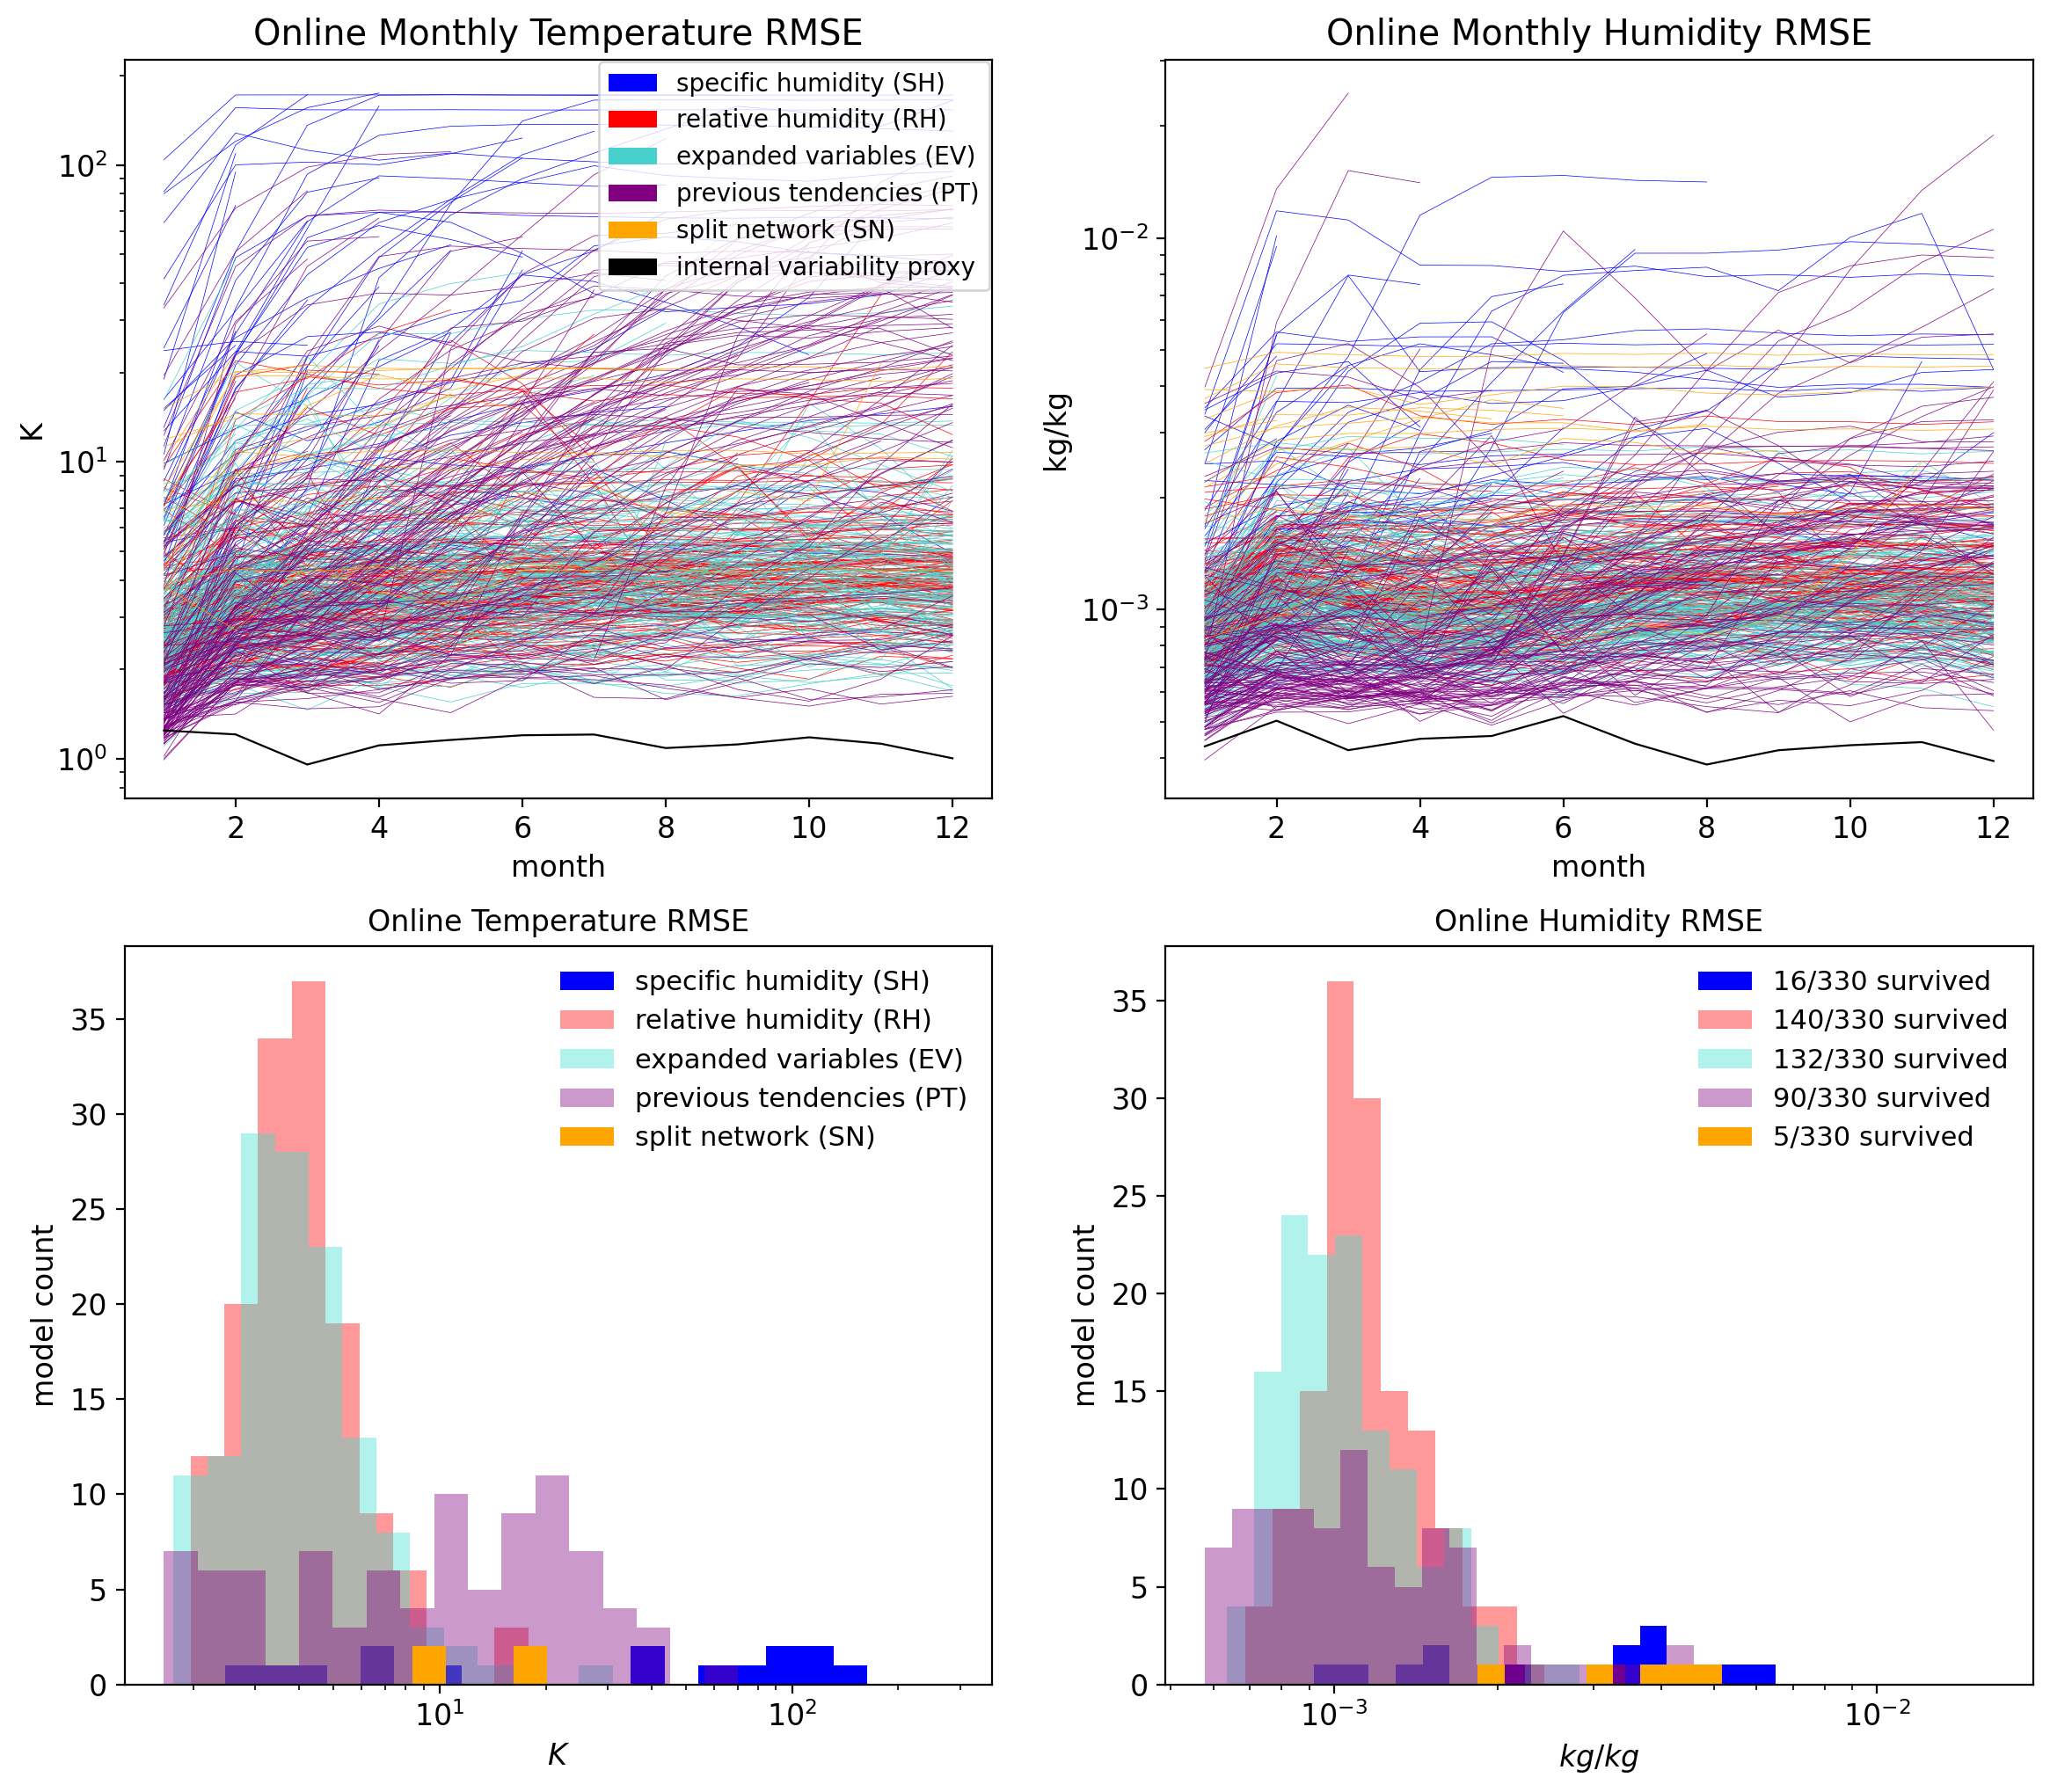

In [22]:
endmag = 310
fig3 = plt.figure(figsize=(14,12))
myfontsize = 12

ax1 = fig3.add_subplot(2,2,1)
plotDiffs(ax1, [diff_T_specific, diff_T_relative, diff_T_expanded, diff_T_previous, diff_T_split], "NNTBP", \
          ["specific humidity (SH)", "relative humidity (RH)", "expanded variables (EV)", "previous tendencies (PT)", "split network (SN)"])

ax2 = fig3.add_subplot(2,2,2)
plotDiffs(ax2, [diff_Q_specific, diff_Q_relative, diff_Q_expanded, diff_Q_previous, diff_Q_split], "NNQBP", \
          ["specific humidity (SH)", "relative humidity (RH)", "expanded variables (EV)", "previous tendencies (PT)", "split network (SN)"], 
          show_legend = False)

ax3 = fig3.add_subplot(2,2,3) # (rows, cols, plots)
ax3.set_xscale("log")

def create_logspace(min_val, log10_diff, num):
    return np.logspace(np.log10(min_val), np.log10(min_val) + log10_diff, num = num)

logbins_temp_specific = create_logspace(full_year_specific["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_relative = create_logspace(full_year_relative["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_expanded = create_logspace(full_year_expanded["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_previous = create_logspace(full_year_previous["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_split = create_logspace(full_year_split["online_rmse_T"].min(), log10_diff = 1.82, num = 20)

ax3.hist(full_year_specific["online_rmse_T"], density = False, bins = logbins_temp_specific, color = "blue")
ax3.hist(full_year_relative["online_rmse_T"], density = False, bins = logbins_temp_relative, color = "red", alpha = .4)
ax3.hist(full_year_expanded["online_rmse_T"], density = False, bins = logbins_temp_expanded, color = "turquoise", alpha = .4)
ax3.hist(full_year_previous["online_rmse_T"], density = False, bins = logbins_temp_previous, color = "purple", alpha = .4)
ax3.hist(full_year_split["online_rmse_T"], density = False, bins = logbins_temp_split, color = "orange")
ax3.legend(["specific humidity (SH)", "relative humidity (RH)", "expanded variables (EV)", "previous tendencies (PT)", "split network (SN)"], frameon = False, fontsize = 11)
ax3.set_xlabel("$K$", fontsize = myfontsize)
ax3.set_ylabel("model count", fontsize = myfontsize)
ax3.set_title("Online Temperature RMSE", fontsize = myfontsize)

logbins_hum_specific = create_logspace(full_year_specific["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_relative = create_logspace(full_year_relative["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_expanded = create_logspace(full_year_expanded["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_previous = create_logspace(full_year_previous["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_split = create_logspace(full_year_split["online_rmse_Q"].min(), log10_diff = .95, num = 20)

ax4 = fig3.add_subplot(2,2,4)
ax4.set_xscale("log")
ax4.hist(full_year_specific["online_rmse_Q"], density = False, bins = logbins_hum_specific, color = "blue")
ax4.hist(full_year_relative["online_rmse_Q"], density = False, bins = logbins_hum_relative, color = "red", alpha = .4)
ax4.hist(full_year_expanded["online_rmse_Q"], density = False, bins = logbins_hum_expanded, color = "turquoise", alpha = .4)
ax4.hist(full_year_previous["online_rmse_Q"], density = False, bins = logbins_hum_previous, color = "purple", alpha = .4)
ax4.hist(full_year_split["online_rmse_Q"], density = False, bins = logbins_hum_split, color = "orange")
ax4.legend([str(len(full_year_specific)) + "/330 survived", 
            str(len(full_year_relative)) + "/330 survived", 
            str(len(full_year_expanded)) + "/330 survived",
            str(len(full_year_previous)) + "/330 survived",
            str(len(full_year_split)) + "/330 survived"], frameon = False, fontsize = 11)

ax4.set_xlabel("$kg/kg$", fontsize = myfontsize)
ax4.set_ylabel("model count", fontsize = myfontsize)
ax4.set_title("Online Humidity RMSE", fontsize = myfontsize)